In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt


import Env

# Import the environment
from Env import CabDriver

# Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load(r'C:/Users/sweet/Downloads/AI Project/TM.npy')

In [4]:
# Check what the max, min and mean time values are. 
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Agent Class

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0001
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.states_tracked = []
        
        # Track state [1,2,3] and action (0,2) at index 2
        self.track_state = np.array(env.state_encod_arch1([1,2,3])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode     
        # exploration
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        # exploitation - greedy
        else:
            #reshaping the state to (1, statesize)
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            # predict the Q_values.
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            # considering only max q-value
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        # Write your code here:
        # save sample  to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # q-value is predicted from the states
            target = self.model.predict(update_input)
            # target q-value
            target_qval = self.model.predict(update_output)

            for i in range(self.batch_size):
                # Terminal
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                # Non-terminal
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Predict q-values and append the action
        self.states_test.append(q_value[0][2])
        
    def get_model_weights(self):
        return self.model.get_weights()

    def save(self, name):
        self.model.save(name)
    

In [7]:
total_episodes = 200

# DQN Block

**Run the episodes, build up replay buffer and train the model.**

In [8]:
episode_time = 24*30 #recharge time  considering as episode time

env = CabDriver()
# Invoke agent class
agent = DQNAgent(36,21)

# to store rewards in each episode
track_epsilon,rewards_per_episode, episodes = [], [],[]
# Rewards for state [1,2,3] being tracked.
rewards_init_state = []
start_time = time.time()
score_tracked = []

for episode in range(total_episodes):

    terminal_state = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Saving initial state
    initial_state = env.state_init

    # Total time 
    total_time = 0  
    while not terminal_state:
        # Getting requests
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        # Getting possible actions
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # Calculating total time
        total_time += step_time
        if (total_time > episode_time):
            terminal_state = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    track_epsilon.append(agent.epsilon);
    if ((episode + 1) % 1 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,score,len(agent.memory),agent.epsilon, total_time))
    
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    #save the  model_weights.h5
    if(episode % 5 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.h5")
        
#saving weights as pickle file 
save_obj(agent.get_model_weights(), "model_weights.pkl")   
elapsed_time = time.time() - start_time
print(elapsed_time)

C:\Users\sweet\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 38ms/step
episode 0, reward -58.0, memory_length 145, epsilon 0.99999 total_time 728.0
Saving Model 0
1/1 [==============================] - 0s 39ms/step
episode 1, reward 72.0, memory_length 289, epsilon 0.9998900059997834 total_time 726.0
1/1 [==============================] - 0s 43ms/step
episode 2, reward 54.0, memory_length 418, epsilon 0.9997900219984668 total_time 722.0
1/1 [==============================] - 0s 37ms/step
episode 3, reward -126.0, memory_length 569, epsilon 0.9996900479950505 total_time 721.0
1/1 [==============================] - 0s 38ms/step
episode 4, reward -197.0, memory_length 712, epsilon 0.9995900839885346 total_time 721.0
1/1 [==============================] - 0s 39ms/step
episode 5, reward -138.0, memory_length 858, epsilon 0.9994901299779195 total_time 731.0
Saving Model 5
1/1 [==============================] - 0s 38ms/step
episode 6, reward -239.0, memory_length 1000, epsilon 0.9993901859622059 total_time 722.

KeyboardInterrupt: 

In [9]:
agent.memory

deque([([2, 0, 2], 0, -5, [2, 1, 2], False),
       ([2, 1, 2], 20, -1.0, [3, 3, 2], False),
       ([3, 3, 2], 13, 32.0, [0, 11, 2], False),
       ([0, 11, 2], 0, -5, [0, 12, 2], False),
       ([0, 12, 2], 5, -6.0, [0, 0, 3], False),
       ([0, 0, 3], 15, -5.0, [2, 10, 3], False),
       ([2, 10, 3], 20, -1.0, [3, 21, 3], False),
       ([3, 21, 3], 6, 27.0, [2, 6, 4], False),
       ([2, 6, 4], 19, -32.0, [2, 16, 4], False),
       ([2, 16, 4], 1, 13.0, [1, 2, 5], False),
       ([1, 2, 5], 3, 16.0, [3, 6, 5], False),
       ([3, 6, 5], 14, 16.0, [1, 10, 5], False),
       ([1, 10, 5], 9, -35.0, [0, 2, 6], False),
       ([0, 2, 6], 0, -5, [0, 3, 6], False),
       ([0, 3, 6], 0, -5, [0, 4, 6], False),
       ([0, 4, 6], 0, -5, [0, 5, 6], False),
       ([0, 5, 6], 19, 11.0, [2, 10, 6], False),
       ([2, 10, 6], 11, 24.0, [3, 16, 6], False),
       ([3, 16, 6], 0, -5, [3, 17, 6], False),
       ([3, 17, 6], 16, 12.0, [4, 20, 6], False),
       ([3, 8, 6], 14, 16.0, [1, 12, 6], F

# Tracking Convergence

In [10]:
agent.states_tracked

[1540.4381,
 558.3683,
 219.97795,
 139.33421,
 162.73271,
 181.28844,
 187.40384,
 194.63562,
 241.05782,
 271.0781]

In [11]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

**Plotting the Q-Value convergence for state action pairs**

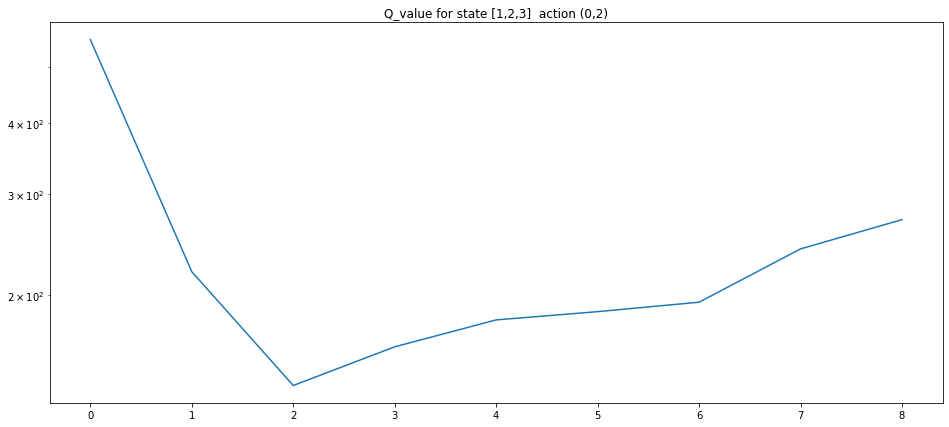

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,2,3]  action (0,2)')
xaxis = np.asarray(range(0, len(state_tracked_sample)))
## We are using log scale because the initial q_values are way to high compared to the steady state value
plt.semilogy(xaxis,np.asarray(state_tracked_sample))
plt.show()

**Tracking Rewards per Episode**

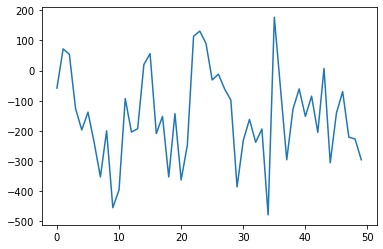

In [13]:
plt.plot(episodes,rewards_per_episode)

In [14]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 5 == 0)]

**Plotting the Rewards per Episode**

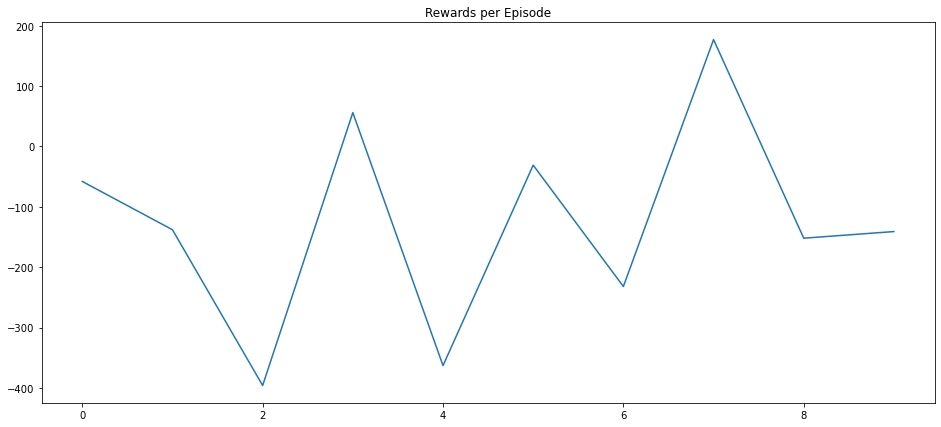

In [15]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per Episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

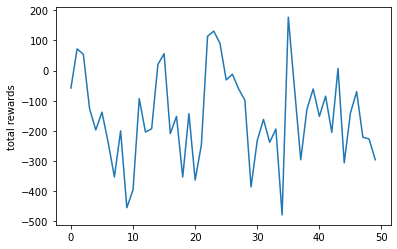

In [16]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [17]:
# Average reward per episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 1:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-58.0, 72.0, 54.0, -126.0, -197.0, -138.0, -239.0, -353.0, -200.0, -455.0, -396.0, -93.0, -204.0, -193.0, 20.0, 56.0, -209.0, -152.0, -353.0, -143.0, -363.0, -247.0, 114.0, 131.0, 90.0, -31.0, -12.0, -61.0, -98.0, -386.0, -232.0, -162.0, -238.0, -194.0, -479.0, 177.0, -60.0, -296.0, -128.0, -61.0, -152.0, -85.0, -205.0, 7.0, -306.0, -141.0, -70.0, -221.0, -227.0, -296.0]


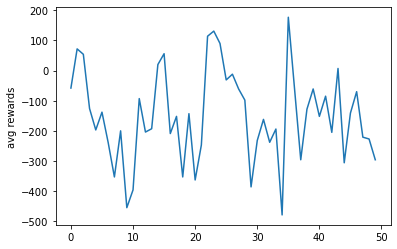

In [18]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

**Epsilon-Decay sample function**

In [25]:
import numpy as np
time = np.arange(0,50)
epsilon = []
for i in range(0,50):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

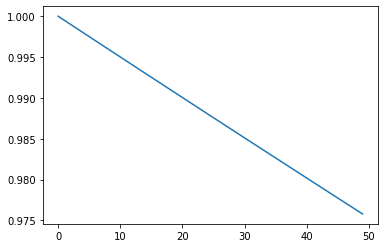

In [26]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()

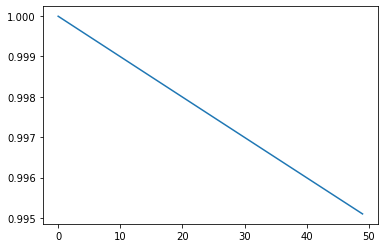

In [27]:
## track_epsilon stores epsilon values
plt.plot(time, track_epsilon)
plt.show()